In [1]:
%matplotlib inline
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils import data
from torchvision import transforms
import torch
from helper import *

In [3]:
DATA_DIR = '../data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [4]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [6]:
class CamVid(data.Dataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes = None, 
            transform = None
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.transform = transform
        
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        mask = np.argmax(mask, axis = 2)

        assert(mask.shape == (360, 480))
        assert(image.shape == (360, 480, 3))
        
        if self.transform :
            image = self.transform(image)
            assert(image.shape == (3, 360, 480))
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

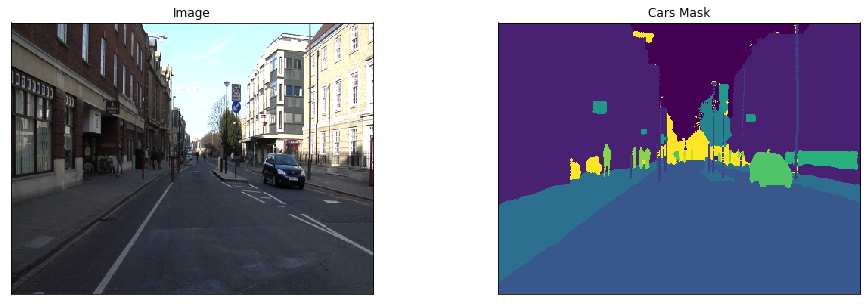

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [39]:
classes = ['sky', 'building', 'pole', 'road', 'pavement', 'tree', 'signsymbol', 'fence', 'car', 'pedestrian', 'bicyclist', 'unlabelled']

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.41189489566336, 0.4251328133025, 0.4326707089857], std = [0.27413549931506, 0.28506257482912, 0.28284674400252])
])
unorm = UnNormalize(mean = [0.41189489566336, 0.4251328133025, 0.4326707089857], std = [0.27413549931506, 0.28506257482912, 0.28284674400252])
dataset = CamVid(x_train_dir, y_train_dir, classes = classes, transform = transform)

image, mask = dataset[23] # get some sample
visualize(
    image=np.transpose(unorm(image), (1, 2, 0)), 
    cars_mask=mask,
)
print(np.unique(mask))

In [27]:
train_dataset = CamVid(
    x_train_dir,
    y_train_dir,
    classes = classes
)

valid_dataset = CamVid(
    x_valid_dir,
    y_valid_dir,
    classes = classes
)

In [28]:
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 1, shuffle = False)

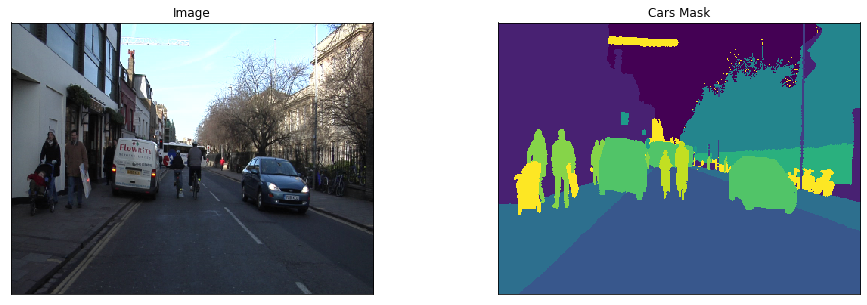

In [30]:
img, mask = next(iter(train_loader))
visualize(
    image=img[2], 
    cars_mask=np.argmax(mask[2], axis = 2),
)